In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import numpy as np

# Read and Format Data

In [2]:
austin_bikeshare_stations_df = pd.read_csv('Data/austin_bikeshare_stations.csv')
austin_bikeshare_trips_df = pd.read_csv('Data/austin_bikeshare_trips.csv')
crimeDataSet_df = pd.read_csv('Data/crimeDataSet.csv')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Convert Dates to Datetime

In [3]:
crimeDataSet_df_filtered = crimeDataSet_df[(crimeDataSet_df['Occurred Date'] >= '01/01/2012') &
                                  (crimeDataSet_df['Occurred Date'] <= '12/31/2018') &
                                  (~crimeDataSet_df['Location'].isna())
                                 ].drop_duplicates(subset=['Incident Number'])

In [4]:
crimeDataSet_df['Occurred Date'] = pd.to_datetime(crimeDataSet_df['Occurred Date'], format='%m/%d/%Y')

In [5]:
austin_bikeshare_trips_df['start_time'] = pd.to_datetime(austin_bikeshare_trips_df['start_time'], format='%Y-%m-%d %H:%M:%S')

# Merge DataFrames (that Jason Created)

In [6]:
mergedCrime1 = pd.read_csv('Data/crime_merged1.csv', sep='\t')
mergedCrime2 = pd.read_csv('Data/crime_merged2.csv', sep='\t')

crimeWDistance = pd.concat([mergedCrime1, mergedCrime2])

# Covert Occurred Date to Datetime
crimeWDistance['Occurred Date'] = pd.to_datetime(crimeWDistance['Occurred Date'], format='%m/%d/%Y')

Check Distribution of crimes around 500 meters of station

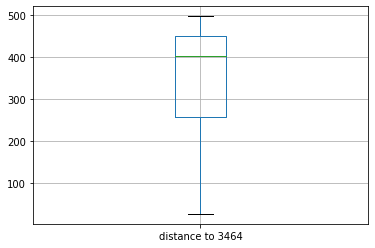

In [7]:
crimeWDistance[crimeWDistance['distance to 3464']<=500].boxplot(column='distance to 3464')

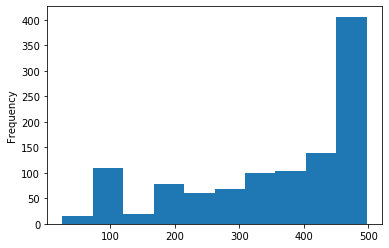

In [8]:
crimeWDistance[crimeWDistance['distance to 3464']<=500]['distance to 3464'].plot.hist()

# Add Periods to Occured Date (crimeWDistance)

## Monthly Periods

In [9]:
crimeWDistance['Occurred Date (Period)'] = crimeWDistance['Occurred Date'].dt.to_period('M')

Count all crimes within X meters of each station for every period

### Example (Station 3464)

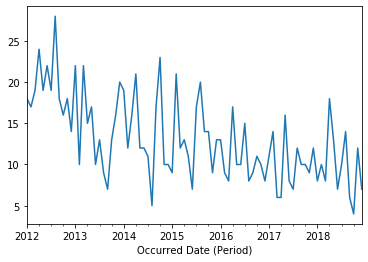

In [10]:
# Specify Distance
maxCrimeDistance = 500

# Select Station
station = 3464
temp = crimeWDistance[crimeWDistance[f'distance to {station}']<=maxCrimeDistance]
crimeWithinStation = temp.groupby('Occurred Date (Period)').count()['Incident Number'].rename(f'{station}')
crimeWithinStation.plot()

# Count number of crimes around station

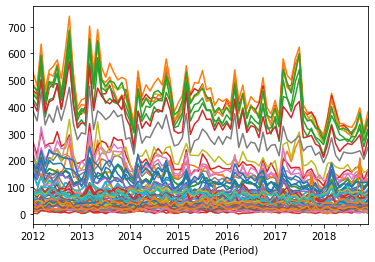

In [11]:
# Get all unique stations
uniqueStations = austin_bikeshare_stations_df['station_id'].unique()
for station in uniqueStations:
    temp = crimeWDistance[crimeWDistance[f'distance to {station}']<=maxCrimeDistance]
    crimePerStation = temp.groupby('Occurred Date (Period)').count()['Incident Number'].rename(f'{station}')
    crimePerStation.plot()

In [12]:
# Get all unique stations
uniqueStations = austin_bikeshare_stations_df['station_id'].unique()

crimePerStationDF = pd.DataFrame(columns=['stationID', 'timePeriod','numCrimeWithinXDistance'])
for station in uniqueStations:
    temp = crimeWDistance[crimeWDistance[f'distance to {station}']<=maxCrimeDistance]
    crimeWithinStation = temp.groupby('Occurred Date (Period)').count()['Incident Number'].rename(f'{station}')

    # Create new temp dataframe
    temp = pd.DataFrame(columns=['stationID', 'timePeriod', 'numCrimeWithinXDistance'])
    temp['timePeriod'] = crimeWithinStation.index
    temp['stationID'] = crimeWithinStation.name
    temp['numCrimeWithinXDistance'] = crimeWithinStation.values
    
    # Append temp dataframe to total dataframe
    crimePerStationDF = pd.concat([crimePerStationDF, temp])

# Add Periods to start time (austin_bikeshare_trips_df)

## Monthly Periods

In [13]:
austin_bikeshare_trips_df['Start Time (Period)'] = austin_bikeshare_trips_df['start_time'].dt.to_period('M')

### Example (Station 3464)

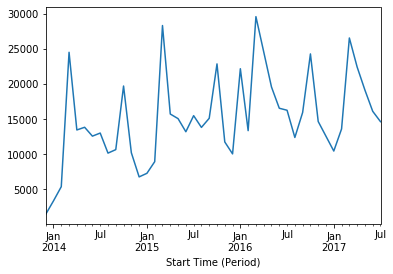

In [14]:
# Select Station
station = 3464
numberOfRidesFromStation = austin_bikeshare_trips_df.groupby('Start Time (Period)').count()['start_station_id'].rename(f'{station}')
numberOfRidesFromStation.plot()

# Count Rides for given period

In [15]:
# Get all unique stations
uniqueStations = austin_bikeshare_stations_df['station_id'].unique()

ridesPerStationDF = pd.DataFrame(columns=['stationID', 'timePeriod', 'prevTimePeriod', 'totalRides'])
for station in uniqueStations:
    numberOfRidesFromStation = austin_bikeshare_trips_df.groupby('Start Time (Period)').count()['start_station_id'].rename(f'{station}')

    # Create new temp dataframe
    temp = pd.DataFrame(columns=['stationID', 'timePeriod', 'prevTimePeriod', 'totalRides'])
    temp['timePeriod'] = numberOfRidesFromStation.index
    temp['prevTimePeriod'] = temp['timePeriod'] - 1
    temp['stationID'] = numberOfRidesFromStation.name
    temp['totalRides'] = numberOfRidesFromStation.values
    
    # Append temp dataframe to total dataframe
    ridesPerStationDF = pd.concat([ridesPerStationDF, temp])

# Merge Crime and Ride Dataframes

In [16]:
crimeVsNumberRidesPerStationDF = pd.merge(crimePerStationDF,
                                         ridesPerStationDF,
                                         how='inner',
                                         left_on=['stationID', 'timePeriod'],
                                         right_on=['stationID', 'prevTimePeriod'],
                                          suffixes=('_x', '')
                                         )
crimeVsNumberRidesPerStationDF = crimeVsNumberRidesPerStationDF.drop(crimeVsNumberRidesPerStationDF.filter(regex='_x$').columns.tolist(), axis=1)
crimeVsNumberRidesPerStationDF = crimeVsNumberRidesPerStationDF.drop(['prevTimePeriod'], axis=1)
crimeVsNumberRidesPerStationDF = crimeVsNumberRidesPerStationDF.rename(columns={'numCrimeWithinXDistance': 'numCrimeWithinXDistancePrevTimePeriod'})

# Testing Crime (prev month) effect on rides (current month)

# Example

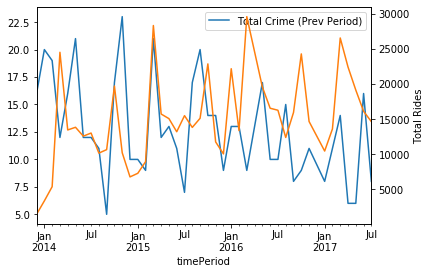

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.4049
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.528
Time:                        18:18:23   Log-Likelihood:                -426.70
No. Observations:                  42   AIC:                             857.4
Df Residuals:                      40   BIC:                             860.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.68e+04   2993.576      5.613      0.0

In [17]:
# Select Station
station = 3464

# Filter Dataframe
crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDF[crimeVsNumberRidesPerStationDF['stationID']==f'{station}']

# Set Index
crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDFFiltered.set_index(['timePeriod'])

# Drop stationID Column
crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDFFiltered.drop(['stationID'], axis=1)

# Rename Columns
crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDFFiltered.rename(columns={'numCrimeWithinXDistancePrevTimePeriod': 'Total Crime (Prev Period)',
                                                                                               'totalRides': 'Total Rides'})
    
crimeVsNumberRidesPerStationDFFiltered.plot(y='Total Crime (Prev Period)')
ax = crimeVsNumberRidesPerStationDFFiltered['Total Rides'].plot(secondary_y=True)
ax.set_ylabel('Total Rides')

plt.show()



# Run Regression
y = np.asarray(crimeVsNumberRidesPerStationDFFiltered['Total Rides'].astype(int))
X = np.asarray(crimeVsNumberRidesPerStationDFFiltered['Total Crime (Prev Period)'].astype(int))
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


## Actual Code

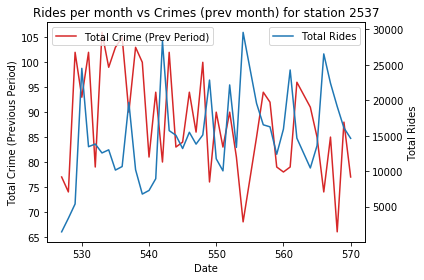

-------------------
Station: 2537
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     5.011
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0308
Time:                        18:18:24   Log-Likelihood:                -424.44
No. Observations:                  42   AIC:                             852.9
Df Residuals:                      40   BIC:                             856.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.271e

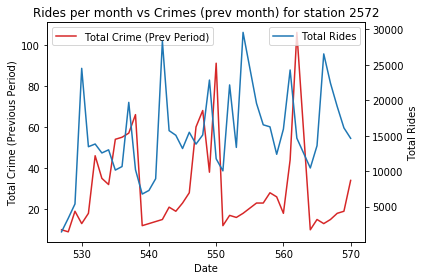

-------------------
Station: 2572
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                   0.03330
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.856
Time:                        18:18:24   Log-Likelihood:                -426.90
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.525e

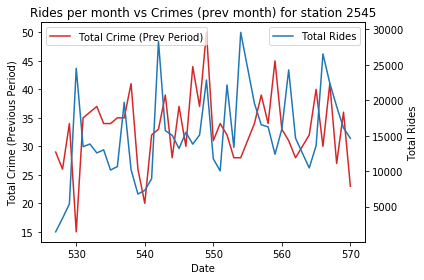

-------------------
Station: 2545
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                   0.07235
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.789
Time:                        18:18:25   Log-Likelihood:                -426.88
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.364e

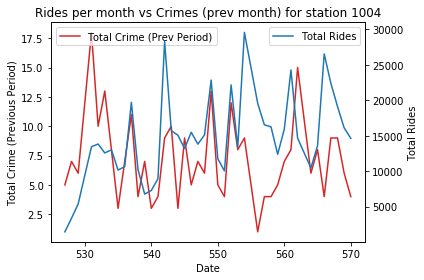

-------------------
Station: 1004
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.700
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.108
Time:                        18:18:26   Log-Likelihood:                -414.70
No. Observations:                  41   AIC:                             833.4
Df Residuals:                      39   BIC:                             836.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.154e

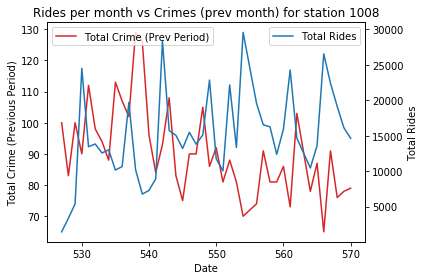

-------------------
Station: 1008
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     8.420
Date:                Fri, 27 Nov 2020   Prob (F-statistic):            0.00601
Time:                        18:18:27   Log-Likelihood:                -422.90
No. Observations:                  42   AIC:                             849.8
Df Residuals:                      40   BIC:                             853.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         3.2e

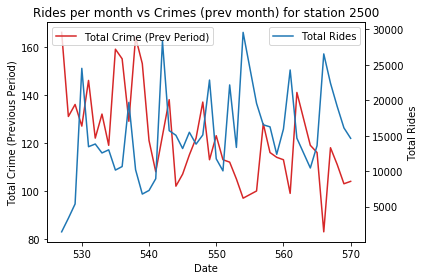

-------------------
Station: 2500
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     17.27
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           0.000166
Time:                        18:18:27   Log-Likelihood:                -419.38
No. Observations:                  42   AIC:                             842.8
Df Residuals:                      40   BIC:                             846.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.761e

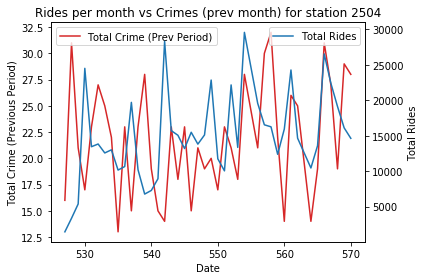

-------------------
Station: 2504
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.3982
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.532
Time:                        18:18:28   Log-Likelihood:                -426.71
No. Observations:                  42   AIC:                             857.4
Df Residuals:                      40   BIC:                             860.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.241e

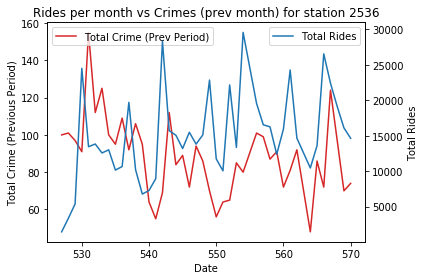

-------------------
Station: 2536
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5940
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.445
Time:                        18:18:29   Log-Likelihood:                -426.61
No. Observations:                  42   AIC:                             857.2
Df Residuals:                      40   BIC:                             860.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.828e

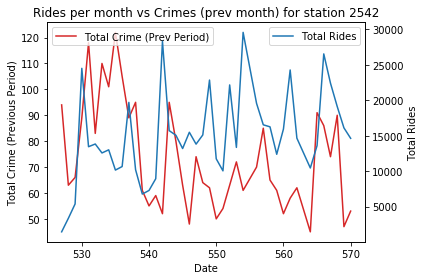

-------------------
Station: 2542
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.3658
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.549
Time:                        18:18:30   Log-Likelihood:                -426.72
No. Observations:                  42   AIC:                             857.4
Df Residuals:                      40   BIC:                             860.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.72e

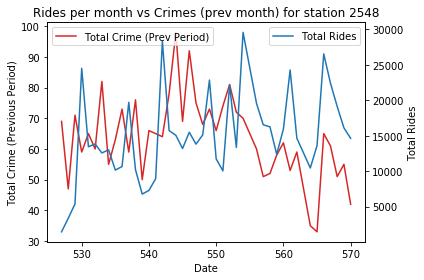

-------------------
Station: 2548
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                   0.08095
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.777
Time:                        18:18:30   Log-Likelihood:                -426.87
No. Observations:                  42   AIC:                             857.7
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.363e

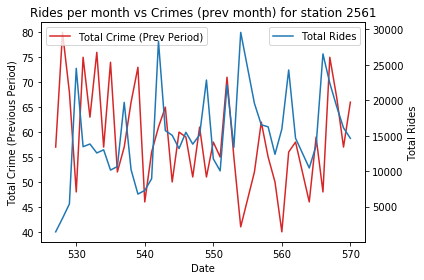

-------------------
Station: 2561
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.350
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0747
Time:                        18:18:31   Log-Likelihood:                -425.23
No. Observations:                  42   AIC:                             854.5
Df Residuals:                      40   BIC:                             857.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.576e

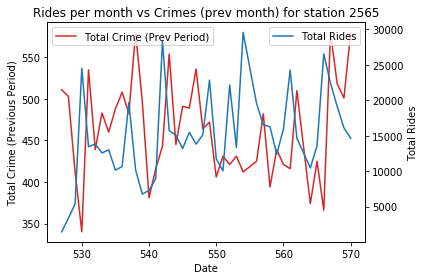

-------------------
Station: 2565
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.790
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.188
Time:                        18:18:31   Log-Likelihood:                -426.00
No. Observations:                  42   AIC:                             856.0
Df Residuals:                      40   BIC:                             859.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.529e

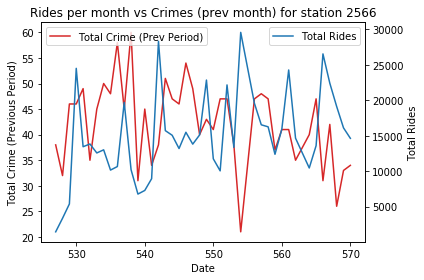

-------------------
Station: 2566
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.473
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.232
Time:                        18:18:32   Log-Likelihood:                -426.16
No. Observations:                  42   AIC:                             856.3
Df Residuals:                      40   BIC:                             859.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.125e

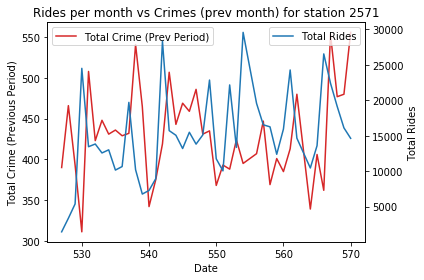

-------------------
Station: 2571
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.1012
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.752
Time:                        18:18:33   Log-Likelihood:                -426.86
No. Observations:                  42   AIC:                             857.7
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.746e

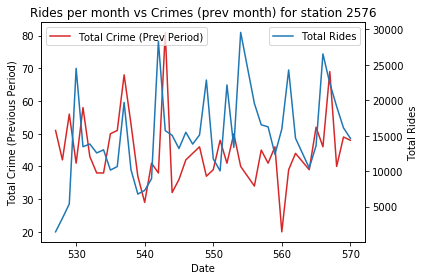

-------------------
Station: 2576
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                   0.06283
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.803
Time:                        18:18:34   Log-Likelihood:                -426.88
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.605e

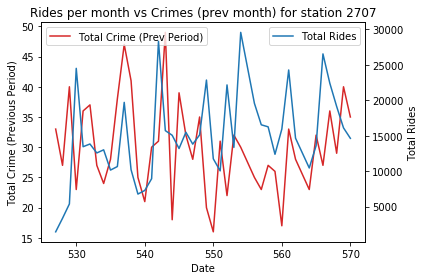

-------------------
Station: 2707
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                    0.1128
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.739
Time:                        18:18:35   Log-Likelihood:                -426.86
No. Observations:                  42   AIC:                             857.7
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.634e

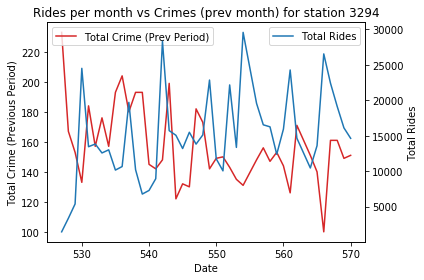

-------------------
Station: 3294
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     15.01
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           0.000387
Time:                        18:18:36   Log-Likelihood:                -420.22
No. Observations:                  42   AIC:                             844.4
Df Residuals:                      40   BIC:                             847.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.545e

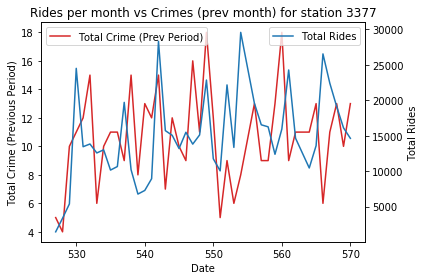

-------------------
Station: 3377
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.487
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.230
Time:                        18:18:37   Log-Likelihood:                -426.15
No. Observations:                  42   AIC:                             856.3
Df Residuals:                      40   BIC:                             859.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.113e

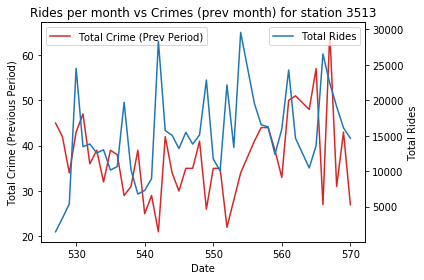

-------------------
Station: 3513
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4247
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.518
Time:                        18:18:38   Log-Likelihood:                -426.69
No. Observations:                  42   AIC:                             857.4
Df Residuals:                      40   BIC:                             860.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.765e

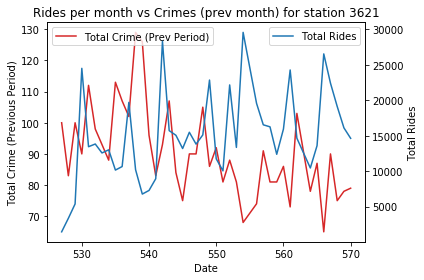

-------------------
Station: 3621
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     8.764
Date:                Fri, 27 Nov 2020   Prob (F-statistic):            0.00515
Time:                        18:18:39   Log-Likelihood:                -422.76
No. Observations:                  42   AIC:                             849.5
Df Residuals:                      40   BIC:                             853.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.218e

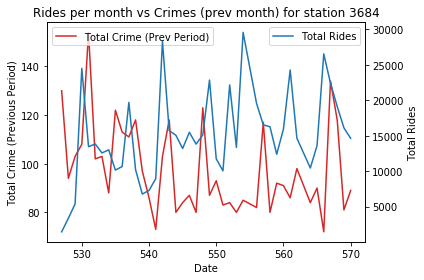

-------------------
Station: 3684
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.5941
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.445
Time:                        18:18:40   Log-Likelihood:                -426.61
No. Observations:                  42   AIC:                             857.2
Df Residuals:                      40   BIC:                             860.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.91e

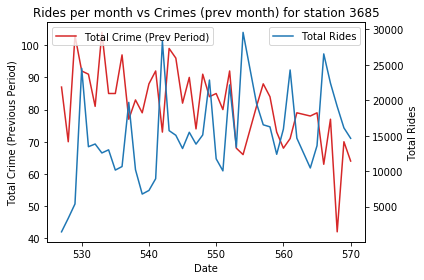

-------------------
Station: 3685
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     4.530
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0395
Time:                        18:18:41   Log-Likelihood:                -424.66
No. Observations:                  42   AIC:                             853.3
Df Residuals:                      40   BIC:                             856.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.87e

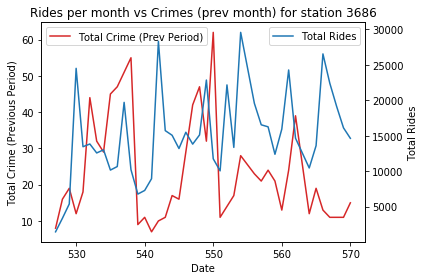

-------------------
Station: 3686
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                   0.05026
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.824
Time:                        18:18:42   Log-Likelihood:                -426.89
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.537e

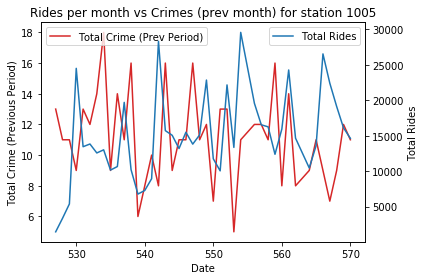

-------------------
Station: 1005
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.3156
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.577
Time:                        18:18:43   Log-Likelihood:                -426.75
No. Observations:                  42   AIC:                             857.5
Df Residuals:                      40   BIC:                             861.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.714e

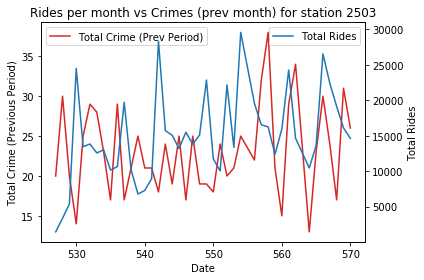

-------------------
Station: 2503
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                  0.003945
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.950
Time:                        18:18:44   Log-Likelihood:                -426.91
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.526e

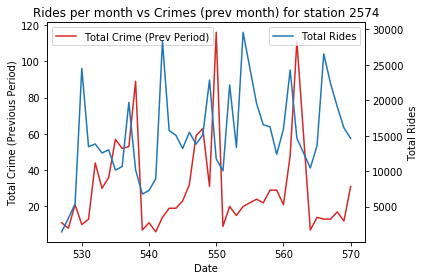

-------------------
Station: 2574
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                   0.07095
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.791
Time:                        18:18:45   Log-Likelihood:                -426.88
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.532e

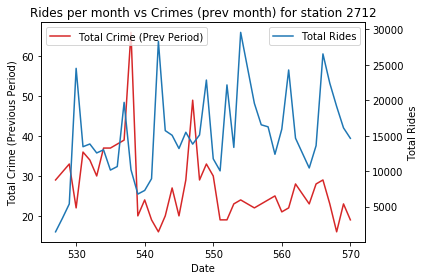

-------------------
Station: 2712
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     2.801
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.102
Time:                        18:18:46   Log-Likelihood:                -425.49
No. Observations:                  42   AIC:                             855.0
Df Residuals:                      40   BIC:                             858.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.981e

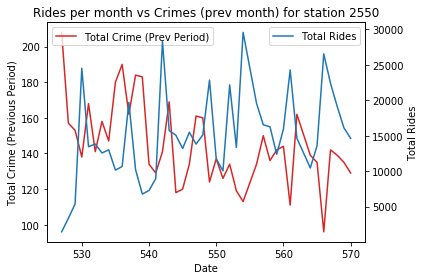

-------------------
Station: 2550
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     17.55
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           0.000150
Time:                        18:18:47   Log-Likelihood:                -419.28
No. Observations:                  42   AIC:                             842.6
Df Residuals:                      40   BIC:                             846.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.712e

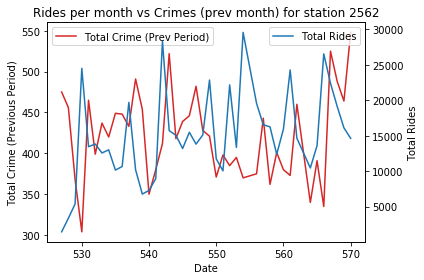

-------------------
Station: 2562
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.728
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.196
Time:                        18:18:48   Log-Likelihood:                -426.03
No. Observations:                  42   AIC:                             856.1
Df Residuals:                      40   BIC:                             859.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.507e

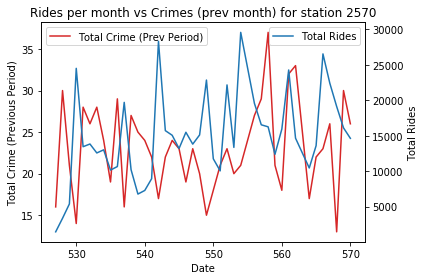

-------------------
Station: 2570
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.5019
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.483
Time:                        18:18:48   Log-Likelihood:                -426.65
No. Observations:                  42   AIC:                             857.3
Df Residuals:                      40   BIC:                             860.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.803e

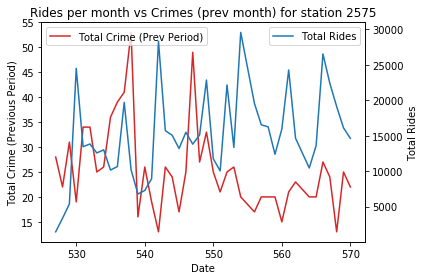

-------------------
Station: 2575
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     1.789
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.189
Time:                        18:18:49   Log-Likelihood:                -426.00
No. Observations:                  42   AIC:                             856.0
Df Residuals:                      40   BIC:                             859.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.886e

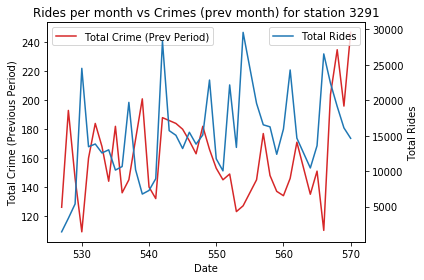

-------------------
Station: 3291
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.022
Method:                 Least Squares   F-statistic:                   0.09851
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.755
Time:                        18:18:50   Log-Likelihood:                -426.86
No. Observations:                  42   AIC:                             857.7
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.668e

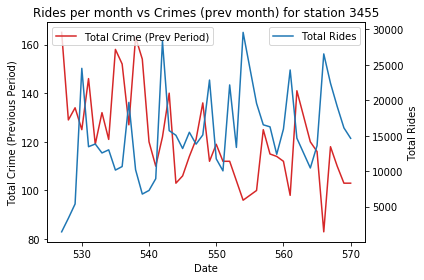

-------------------
Station: 3455
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     17.70
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           0.000142
Time:                        18:18:51   Log-Likelihood:                -419.22
No. Observations:                  42   AIC:                             842.4
Df Residuals:                      40   BIC:                             845.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.787e

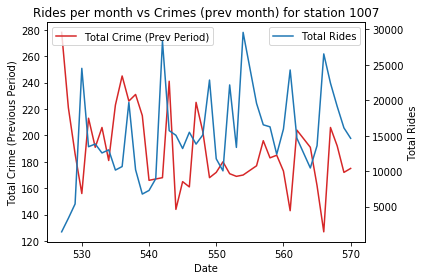

-------------------
Station: 1007
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     13.59
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           0.000676
Time:                        18:18:52   Log-Likelihood:                -420.77
No. Observations:                  42   AIC:                             845.5
Df Residuals:                      40   BIC:                             849.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.481e

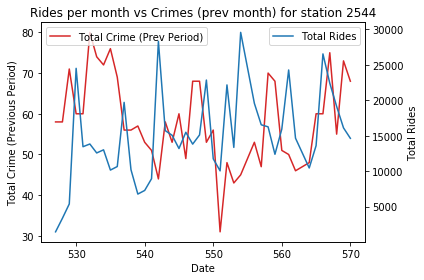

-------------------
Station: 2544
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.431
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.239
Time:                        18:18:53   Log-Likelihood:                -426.18
No. Observations:                  42   AIC:                             856.4
Df Residuals:                      40   BIC:                             859.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.14e

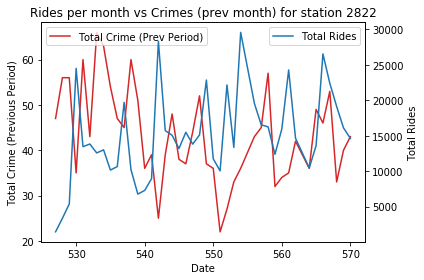

-------------------
Station: 2822
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     5.787
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0209
Time:                        18:18:53   Log-Likelihood:                -424.08
No. Observations:                  42   AIC:                             852.2
Df Residuals:                      40   BIC:                             855.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.446e

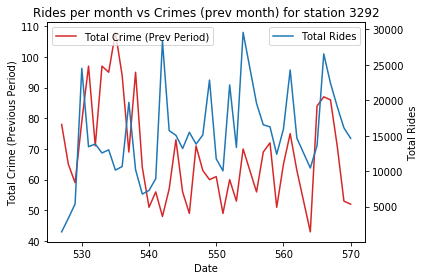

-------------------
Station: 3292
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                 0.0004480
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.983
Time:                        18:18:54   Log-Likelihood:                -426.92
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.491e

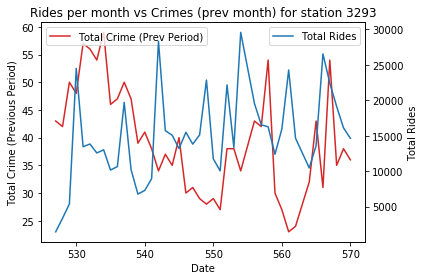

-------------------
Station: 3293
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.644
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.207
Time:                        18:18:55   Log-Likelihood:                -426.07
No. Observations:                  42   AIC:                             856.1
Df Residuals:                      40   BIC:                             859.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        2.02e

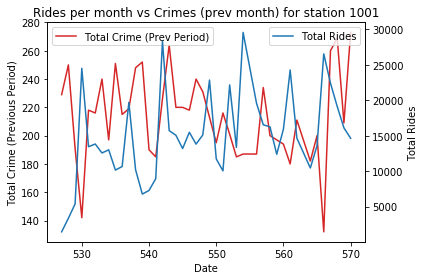

-------------------
Station: 1001
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     3.450
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0706
Time:                        18:18:56   Log-Likelihood:                -425.18
No. Observations:                  42   AIC:                             854.4
Df Residuals:                      40   BIC:                             857.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.741e

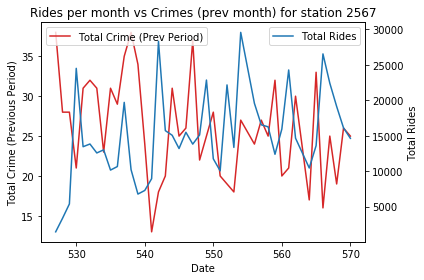

-------------------
Station: 2567
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     6.964
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0118
Time:                        18:18:56   Log-Likelihood:                -423.55
No. Observations:                  42   AIC:                             851.1
Df Residuals:                      40   BIC:                             854.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.524e

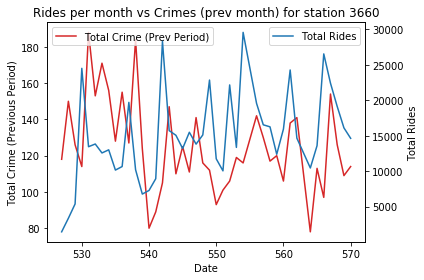

-------------------
Station: 3660
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.3112
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.580
Time:                        18:18:57   Log-Likelihood:                -426.75
No. Observations:                  42   AIC:                             857.5
Df Residuals:                      40   BIC:                             861.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.779e

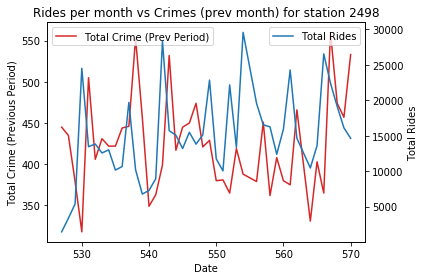

-------------------
Station: 2498
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.4887
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.489
Time:                        18:18:59   Log-Likelihood:                -426.66
No. Observations:                  42   AIC:                             857.3
Df Residuals:                      40   BIC:                             860.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.021e

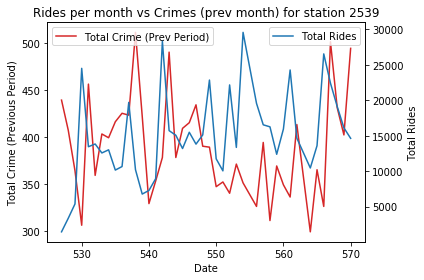

-------------------
Station: 2539
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.638
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.208
Time:                        18:19:00   Log-Likelihood:                -426.07
No. Observations:                  42   AIC:                             856.1
Df Residuals:                      40   BIC:                             859.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.431e

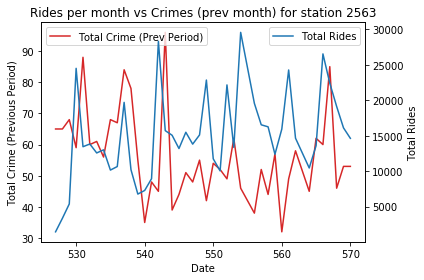

-------------------
Station: 2563
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9164
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.344
Time:                        18:19:00   Log-Likelihood:                -426.44
No. Observations:                  42   AIC:                             856.9
Df Residuals:                      40   BIC:                             860.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.879e

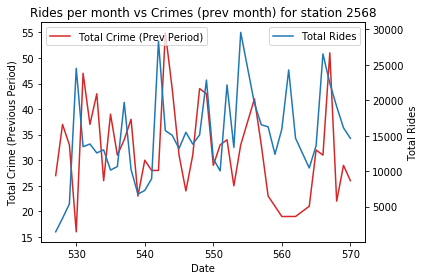

-------------------
Station: 2568
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                   0.01030
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.920
Time:                        18:19:01   Log-Likelihood:                -426.91
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.465e

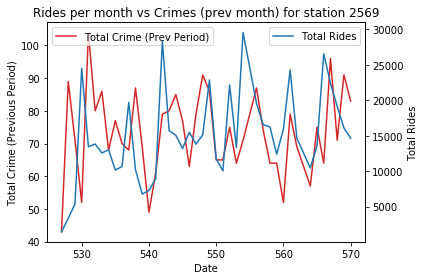

-------------------
Station: 2569
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.512
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.226
Time:                        18:19:02   Log-Likelihood:                -426.14
No. Observations:                  42   AIC:                             856.3
Df Residuals:                      40   BIC:                             859.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8204.5

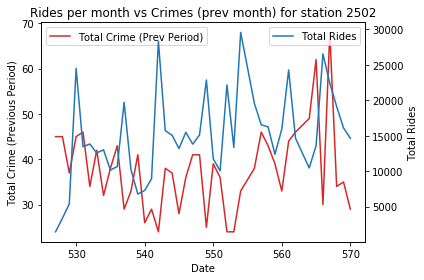

-------------------
Station: 2502
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8404
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.365
Time:                        18:19:02   Log-Likelihood:                -426.48
No. Observations:                  42   AIC:                             857.0
Df Residuals:                      40   BIC:                             860.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.872e

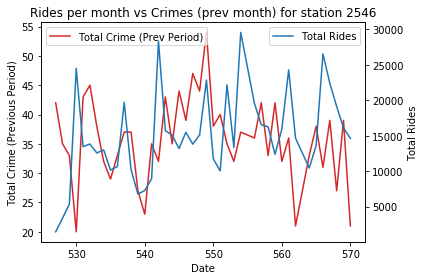

-------------------
Station: 2546
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                  0.001153
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.973
Time:                        18:19:03   Log-Likelihood:                -426.92
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.484e

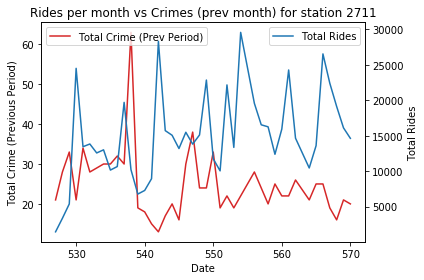

-------------------
Station: 2711
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     2.182
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.147
Time:                        18:19:04   Log-Likelihood:                -425.80
No. Observations:                  42   AIC:                             855.6
Df Residuals:                      40   BIC:                             859.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.931e

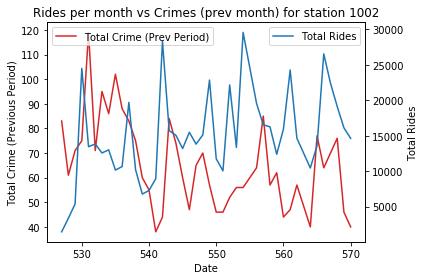

-------------------
Station: 1002
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.9207
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.343
Time:                        18:19:04   Log-Likelihood:                -426.44
No. Observations:                  42   AIC:                             856.9
Df Residuals:                      40   BIC:                             860.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.844e

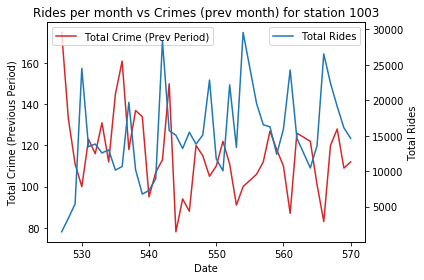

-------------------
Station: 1003
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     11.49
Date:                Fri, 27 Nov 2020   Prob (F-statistic):            0.00158
Time:                        18:19:05   Log-Likelihood:                -421.61
No. Observations:                  42   AIC:                             847.2
Df Residuals:                      40   BIC:                             850.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.244e

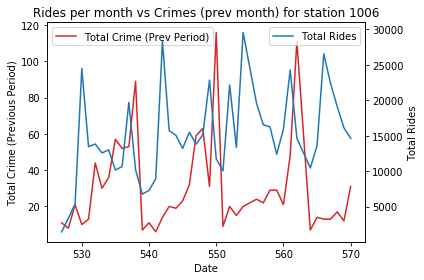

-------------------
Station: 1006
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                   0.07065
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.792
Time:                        18:19:05   Log-Likelihood:                -426.88
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.532e

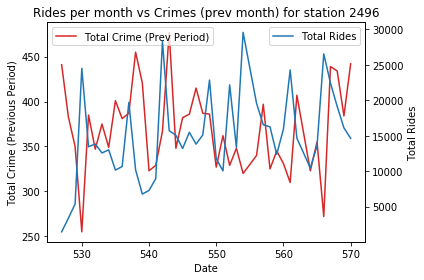

-------------------
Station: 2496
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     4.211
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0467
Time:                        18:19:06   Log-Likelihood:                -424.81
No. Observations:                  42   AIC:                             853.6
Df Residuals:                      40   BIC:                             857.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.018e

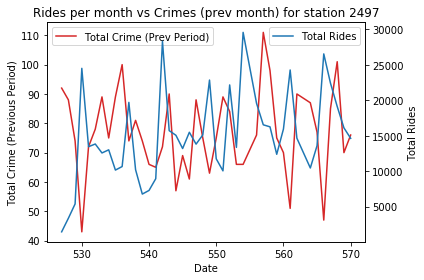

-------------------
Station: 2497
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     6.295
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0163
Time:                        18:19:06   Log-Likelihood:                -423.85
No. Observations:                  42   AIC:                             851.7
Df Residuals:                      40   BIC:                             855.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.751e

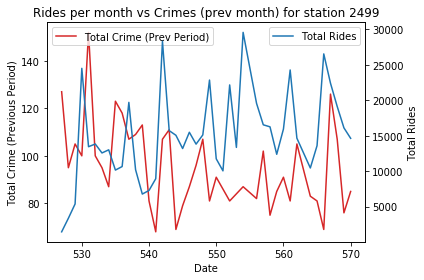

-------------------
Station: 2499
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.492
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.229
Time:                        18:19:07   Log-Likelihood:                -426.15
No. Observations:                  42   AIC:                             856.3
Df Residuals:                      40   BIC:                             859.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.139e

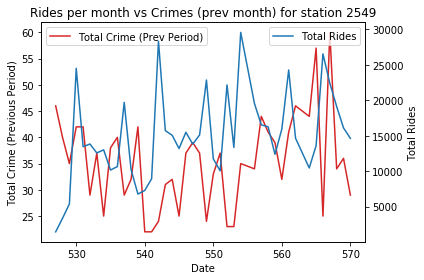

-------------------
Station: 2549
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6818
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.414
Time:                        18:19:07   Log-Likelihood:                -426.56
No. Observations:                  42   AIC:                             857.1
Df Residuals:                      40   BIC:                             860.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.832e

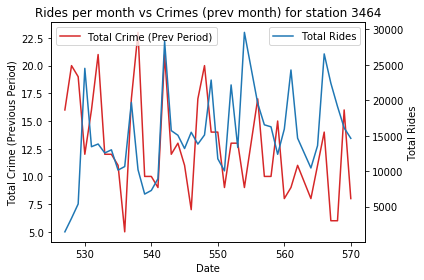

-------------------
Station: 3464
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.4049
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.528
Time:                        18:19:08   Log-Likelihood:                -426.70
No. Observations:                  42   AIC:                             857.4
Df Residuals:                      40   BIC:                             860.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.68e

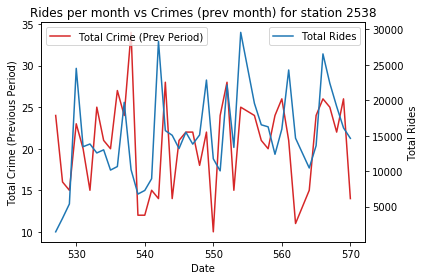

-------------------
Station: 2538
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     3.342
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0750
Time:                        18:19:08   Log-Likelihood:                -425.23
No. Observations:                  42   AIC:                             854.5
Df Residuals:                      40   BIC:                             857.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8359.0

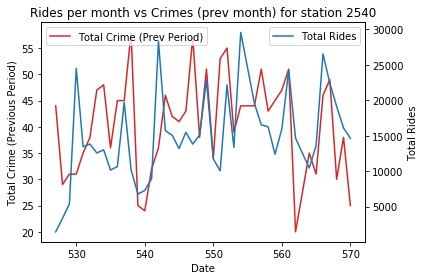

-------------------
Station: 2540
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     3.547
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0669
Time:                        18:19:09   Log-Likelihood:                -425.13
No. Observations:                  42   AIC:                             854.3
Df Residuals:                      40   BIC:                             857.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7137.3

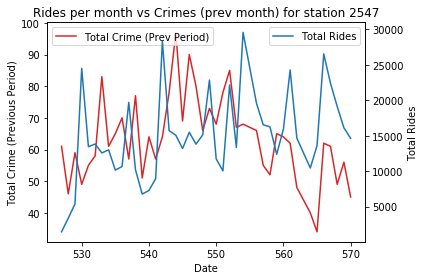

-------------------
Station: 2547
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.4310
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.515
Time:                        18:19:10   Log-Likelihood:                -426.69
No. Observations:                  42   AIC:                             857.4
Df Residuals:                      40   BIC:                             860.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.186e

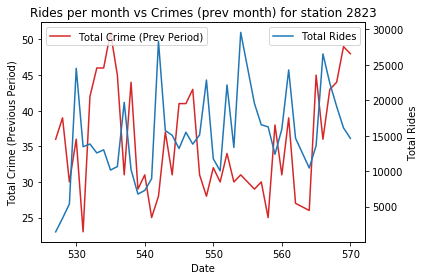

-------------------
Station: 2823
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.2127
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.647
Time:                        18:19:10   Log-Likelihood:                -426.80
No. Observations:                  42   AIC:                             857.6
Df Residuals:                      40   BIC:                             861.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.718e

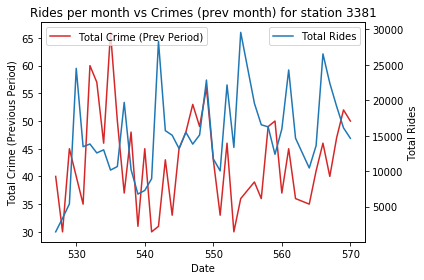

-------------------
Station: 3381
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                  0.009947
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.921
Time:                        18:19:11   Log-Likelihood:                -426.91
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.451e

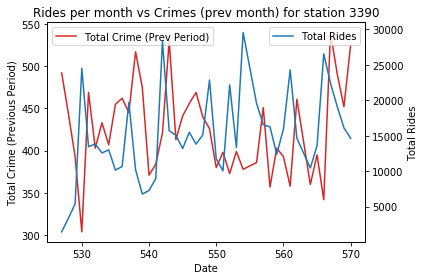

-------------------
Station: 3390
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.644
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.112
Time:                        18:19:11   Log-Likelihood:                -425.57
No. Observations:                  42   AIC:                             855.1
Df Residuals:                      40   BIC:                             858.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.753e

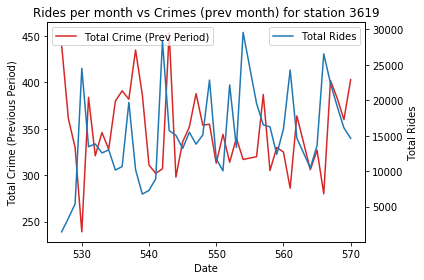

-------------------
Station: 3619
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     6.093
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0179
Time:                        18:19:12   Log-Likelihood:                -423.94
No. Observations:                  42   AIC:                             851.9
Df Residuals:                      40   BIC:                             855.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.277e

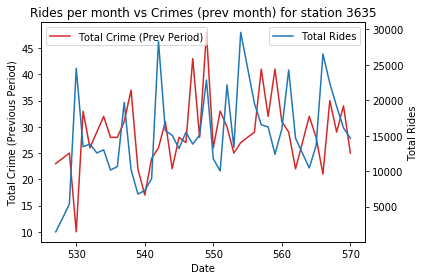

-------------------
Station: 3635
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.017
Method:                 Least Squares   F-statistic:                    0.3241
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.572
Time:                        18:19:12   Log-Likelihood:                -426.75
No. Observations:                  42   AIC:                             857.5
Df Residuals:                      40   BIC:                             861.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.261e

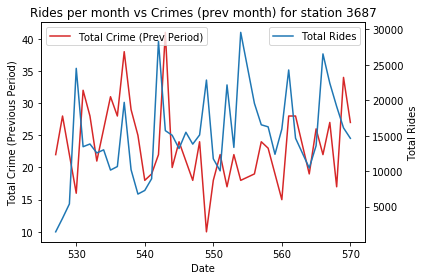

-------------------
Station: 3687
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8949
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.350
Time:                        18:19:13   Log-Likelihood:                -426.45
No. Observations:                  42   AIC:                             856.9
Df Residuals:                      40   BIC:                             860.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.859e

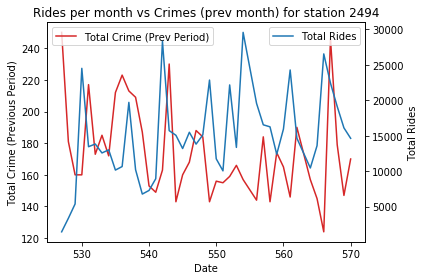

-------------------
Station: 2494
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     3.830
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0573
Time:                        18:19:14   Log-Likelihood:                -425.00
No. Observations:                  42   AIC:                             854.0
Df Residuals:                      40   BIC:                             857.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.613e

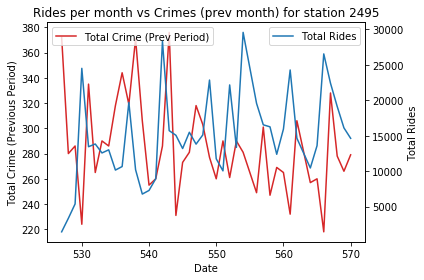

-------------------
Station: 2495
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     5.497
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0241
Time:                        18:19:14   Log-Likelihood:                -424.21
No. Observations:                  42   AIC:                             852.4
Df Residuals:                      40   BIC:                             855.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.171e

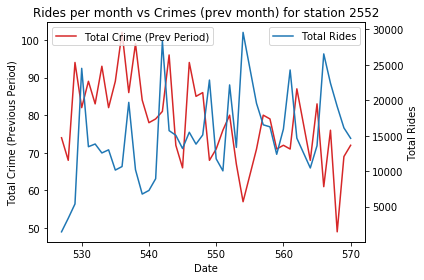

-------------------
Station: 2552
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     4.260
Date:                Fri, 27 Nov 2020   Prob (F-statistic):             0.0456
Time:                        18:19:15   Log-Likelihood:                -424.79
No. Observations:                  42   AIC:                             853.6
Df Residuals:                      40   BIC:                             857.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.866e

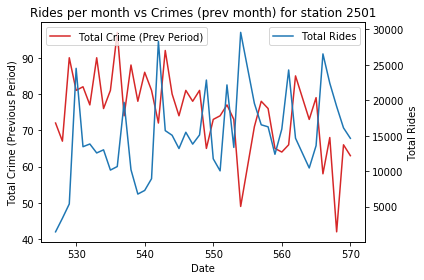

-------------------
Station: 2501
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     10.18
Date:                Fri, 27 Nov 2020   Prob (F-statistic):            0.00277
Time:                        18:19:16   Log-Likelihood:                -422.16
No. Observations:                  42   AIC:                             848.3
Df Residuals:                      40   BIC:                             851.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.489e

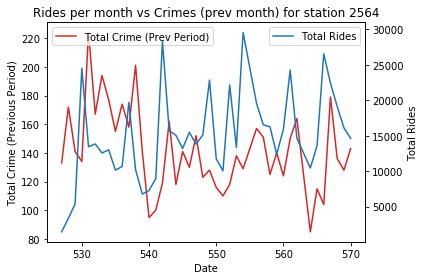

-------------------
Station: 2564
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.4018
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.530
Time:                        18:19:17   Log-Likelihood:                -426.71
No. Observations:                  42   AIC:                             857.4
Df Residuals:                      40   BIC:                             860.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.81e

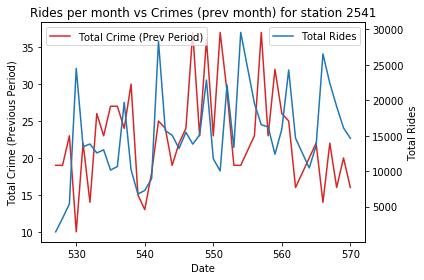

-------------------
Station: 2541
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.025
Method:                 Least Squares   F-statistic:                  0.006924
Date:                Fri, 27 Nov 2020   Prob (F-statistic):              0.934
Time:                        18:19:18   Log-Likelihood:                -426.91
No. Observations:                  42   AIC:                             857.8
Df Residuals:                      40   BIC:                             861.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.471e

In [18]:
# Get all unique stations
uniqueStations = austin_bikeshare_stations_df['station_id'].unique()

saveResults=False
if saveResults:
    # Create Empty DataFrame
    columnNames = ['Alpha Estimate',
                   'Alpha Standard Error',
                   'Alpha T-Stat',
                   'Beta Estimate',
                   'Beta Standard Error',
                   'Beta T-Stat'
                   ]
    exportDF = pd.DataFrame(index=uniqueStations, columns=columnNames)
    
for station in uniqueStations:
    # Filter Dataframe
    crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDF[crimeVsNumberRidesPerStationDF['stationID']==f'{station}']

    # Set Index
    crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDFFiltered.set_index(['timePeriod'])

    # Drop stationID Column
    crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDFFiltered.drop(['stationID'], axis=1)

    # Rename Columns
    crimeVsNumberRidesPerStationDFFiltered = crimeVsNumberRidesPerStationDFFiltered.rename(columns={'numCrimeWithinXDistancePrevTimePeriod': 'Total Crime (Prev Period)',
                                                                                                   'totalRides': 'Total Rides'})
    if saveResults:
        currentPath = os.getcwd()
        newDirPath = f"{currentPath}/Results"
        if not os.path.exists(newDirPath):
            os.mkdir(newDirPath)
    
    # Plot
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Total Crime (Previous Period)')
    ax1.plot(crimeVsNumberRidesPerStationDFFiltered['Total Crime (Prev Period)'].index,
             crimeVsNumberRidesPerStationDFFiltered['Total Crime (Prev Period)'].values, 
             color=color,
             label='Total Crime (Prev Period)'
            )
    ax1.tick_params(axis='y')
    ax1.set_title(f'Rides per month vs Crimes (prev month) for station {station}')
    ax1.legend(loc=2)
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Total Rides')  # we already handled the x-label with ax1
    ax2.plot(crimeVsNumberRidesPerStationDFFiltered['Total Rides'].index,
             crimeVsNumberRidesPerStationDFFiltered['Total Rides'].values, 
             color=color,
             label='Total Rides'
            )
    ax2.tick_params(axis='y')
    ax2.legend(loc=1)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if saveResults:
        plt.savefig(f"{newDirPath}/Figures/{station}_figure")
        
    plt.show()

    # Run Regression
    y = np.asarray(crimeVsNumberRidesPerStationDFFiltered['Total Rides'].astype(int))
    X = np.asarray(crimeVsNumberRidesPerStationDFFiltered['Total Crime (Prev Period)'].astype(int))
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()
    print('-------------------')
    print(f"Station: {station}")
    print(results.summary())
    print('-------------------')
    print('\n')
    
    if saveResults:
        exportDF.loc[station] = [results.params[0], 
                                 results.bse[0],
                                 results.tvalues[0],
                                 results.params[1], 
                                 results.bse[1],
                                 results.tvalues[1],
                                ]
        

if saveResults:
    exportDF.to_csv(f"{newDirPath}/SummaryResults/results.csv")    
    
    